### This notebook pulls in nbart for a polygon in the Stuart corridor where we observed terrain shadowing, and plots a false color, wetness and TCI summary.

In [2]:
### updated to pull back both nbar and nbart

In [3]:
%matplotlib inline

#get some libraries
import datacube
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
import json
import pandas as pd
import shapely
from shapely.geometry import shape
import numpy as np #need this for pq fuser

#libraries for polygon and polygon mask
import fiona
import shapely.geometry
import rasterio.features
import rasterio
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser as pq_fuser
from datacube.storage.masking import mask_valid_data as mask_invalid_data

#for writing to netcdf
from datacube.storage.storage import write_dataset_to_netcdf
#dealing with system commands
import sys

from shapely.geometry import shape
import matplotlib.gridspec as gridspec
import numpy as np
import pickle
import os
import geopandas as gpd

#libraries for dealing with time
from time import strftime
from datetime import datetime


#libraries for plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib.colors import LinearSegmentedColormap
#library for suppressing xarray warning
import warnings


###testing these for making an animation
from matplotlib import animation, rc
from IPython.display import HTML

In [4]:
#This defines the function that converts a linear vector file into a string of x,y coordinates
def geom_query(geom, geom_crs='EPSG:3577'):
    """
    Create datacube query snippet for geometry
    """
    return {
        'x': (geom.bounds[0], geom.bounds[2]),
        'y': (geom.bounds[1], geom.bounds[3]),
        'crs': geom_crs
    }


def warp_geometry(geom, crs_crs, dst_crs):
    """
    warp geometry from crs_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(crs_crs, dst_crs, shapely.geometry.mapping(geom)))


def transect(data, geom, resolution, method='nearest', tolerance=None):
    """
    gets the transect
    """
    #Changed for py3 compatibility 17.03.17
    dist = [i for i in range(0, int(geom.length), resolution)]
    #points = zip(*[geom.interpolate(d).coords[0] for d in dist]) py2
    points = list(zip(*[geom.interpolate(d).coords[0] for d in dist])) #py3
    indexers = {
        data.crs.dimensions[0]: list(points[1]),
        data.crs.dimensions[1]: list(points[0])        
    }
    return data.sel_points(xr.DataArray(dist, name='distance', dims=['distance']),
                           method=method,
                           tolerance=tolerance,
                           **indexers)

#mask to use with our polygons to calculate wet and dry years 
#(comes from http://agdc-v2.readthedocs.io/en/stable/user/guide.html#code-recipes)
def geometry_mask(geoms, geobox, all_touched=False, invert=False):
    """
    Create a mask from shapes.

    By default, mask is intended for use as a
    numpy mask, where pixels that overlap shapes are False.
    :param list[Geometry] geoms: geometries to be rasterized
    :param datacube.utils.GeoBox geobox:
    :param bool all_touched: If True, all pixels touched by geometries will be burned in. If
                             false, only pixels whose center is within the polygon or that
                             are selected by Bresenham's line algorithm will be burned in.
    :param bool invert: If True, mask will be True for pixels that overlap shapes.
    """
    return rasterio.features.geometry_mask([geom.to_crs(geobox.crs) for geom in geoms],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)

### load the polygon from a file, specifying the index of the polygon we have selected by looking at the shapefile and the TCI summary for the Stuart corridor

In [5]:
#code to work with a polygon input rather than a lat/long box
# #pick a shape file
shape_file = ('/g/data/r78/rjd547/groundwater_activities/Stuart_Cor/shapefiles/StHwy_albs_w5kgrid.shp')
# open all the shapes within the shape file
shapes = fiona.open(shape_file)

#i is the index of the shape file we have chosen
i =5373 #working with the first shape here
print('i is :'+str(i))
if i > len(shapes):
    print('index not in the range for the shapefile: '+str(i)+' not in '+str(len(shapes)))
    sys.exit(0)

i is :5373


## Set geometry and coordinate reference systems up for datacube query

In [6]:
#set geom coordinate reference system as what we read in
geom_crs = geometry.CRS(shapes.crs_wkt)
geo = shapes[i]['geometry']
geom = geometry.Geometry(geo, crs=geom_crs)
geom_bs = shapely.geometry.shape(next(iter(shapes))['geometry'])

#tell the datacube which app to use - this is just for accounting purposes and doesn't affect
#the data we are actually reading in
dc = datacube.Datacube(app='dc-nbart')

### Define the epoch

In [7]:
#Define temporal range - testing with one year of data
start_of_epoch = '1987-10-01'
#need a variable here that defines a rolling 'latest observation'  
end_of_epoch =  '2016-10-01'
print ('temporal range is '+start_of_epoch+' to '+end_of_epoch)

temporal range is 1987-10-01 to 2016-10-01


### Set time and bands and sensors of interest for dc query. Specify tasselled cap wetness coefficients for each sensor. Group pixel quality by solar day to avoid North-South overlap

In [8]:
#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = ['blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     'swir2'
                     ]

#Define sensors of interest
sensor1 = 'ls5'
sensor2 = 'ls7'
sensor3 = 'ls8'

#Group PQ by solar day to avoid idiosyncracies of N/S overlap differences in PQ algorithm performance
pq_albers_product = dc.index.products.get_by_name(sensor1+'_pq_albers')
valid_bit = pq_albers_product.measurements['pixelquality']['flags_definition']['contiguous']['bits']

#load sensor specific band adjustment tuples for TSS and brightness
brightness_coeff = {}
brightness_coeff['ls5'] = (0.304, 0.279, 0.434, 0.559, 0.508, 0.186)
brightness_coeff['ls7'] = (0.304, 0.279, 0.434, 0.559, 0.508, 0.186)
#brightness_coeff['ls7'] = (0.3561, 0.3972, 0.3904, 0.6966, 0.2286, 0.1596)
brightness_coeff['ls8'] = (0.3029, 0.2786, 0.4733, 0.5599, 0.508, 0.1872)

greenness_coeff = {}
greenness_coeff['ls5'] = (-0.285, -0.244, -0.544, 0.724, 0.084, -0.180)
greenness_coeff['ls7'] = (-0.285, -0.244, -0.544, 0.724, 0.084, -0.180)
#greenness_coeff['ls7'] = (-0.3344, -0.3544, -0.4556, 0.6966, -0.0242, -0.263)
greenness_coeff['ls8'] = (-0.2941, -0.243, -0.5424, 0.7276, 0.0713, -0.1608)

wetness_coeff = {}
wetness_coeff['ls5'] = (0.151, 0.179, 0.330, 0.341, -0.711, -0.457)
wetness_coeff['ls7'] = (0.151, 0.179, 0.330, 0.341, -0.711, -0.457)
wetness_coeff['ls8'] = (0.1511, 0.1973, 0.3283, 0.3407, -0.7117, -0.4559)

tsm_coeff = {
    'ls5': (3983, 1.6246),
    'ls7': (3983, 1.6246),
    'ls8': (3957, 1.6436)
}

### query

In [9]:
query = {
    'time': (start_of_epoch, end_of_epoch), 'geopolygon': geom
}


## define paths to load and save data

In [10]:
savetime=datetime.now().strftime('%Y%m%d_%H%M')

In [11]:
#the actual rainfall file. ##FIXME include date range, and try:except when you have time ###
nbarpq_savein = '/g/data/r78/rjd547/groundwater_activities/Stuart_Cor/NBarPQ/'

### pull in nbar from datacube

In [12]:
try:
    #try to get the NBAR and PQ data for sensor n from a pickle file saved earlier
    f = open(nbarpq_savein+'NBARPQ_data'+str(i)+'.pkl', 'rb')
    NBPQdata = pickle.load(f)
    sensor1_nbar = NBPQdata['sensor1_nbar']
    sensor1_pq = NBPQdata['sensor1_pq']
    sensor2_nbar = NBPQdata['sensor2_nbar']
    sensor2_pq = NBPQdata['sensor2_pq']
    sensor3_nbar = NBPQdata['sensor3_nbar']
    sensor3_pq = NBPQdata['sensor3_pq']
    print('loaded sensor NBAR and PQ from file')
    f.close()
except FileNotFoundError:
    #Retrieve the NBAR and PQ data for sensor n from the datacube
    sensor1_nbar = dc.load(product= sensor1+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
    sensor1_pq = dc.load(product= sensor1+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)        
    print('loaded sensor1 NBAR and PQ from datacube')

    sensor2_nbar = dc.load(product= sensor2+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
    sensor2_pq = dc.load(product= sensor2+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)                  
    print('loaded sensor2 NBAR and PQ from datacube')

    sensor3_nbar = dc.load(product= sensor3+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
    sensor3_pq = dc.load(product= sensor3+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)                  
    print('loaded sensor3 NBAR and PQ from datacube')

    #make a dictionary of the data we want to save
    pickle_vars = {'sensor1_nbar':sensor1_nbar,'sensor1_pq':sensor1_pq,
              'sensor2_nbar':sensor2_nbar,'sensor2_pq':sensor2_pq,
              'sensor3_nbar':sensor3_nbar,'sensor3_pq':sensor3_pq}

    f = open(nbarpq_savein+'NBARPQ_data'+str(i)+'.pkl', 'wb')
    pickle.dump(pickle_vars,f) 
    print('saved sensor NBAR and PQ data to file')
    #pickle.dump(pickle_vars,f,protocol = 2, fix_imports = True) #maintain compatibility with python 2
    f.close()

loaded sensor NBAR and PQ from file


In [13]:
#save attributes
crs = sensor1_nbar.crs
crswkt = sensor1_nbar.crs.wkt
affine = sensor1_nbar.affine

s1_cloud_free = masking.make_mask(sensor1_pq, 
                              cloud_acca='no_cloud',
                              cloud_shadow_acca = 'no_cloud_shadow',
                              cloud_shadow_fmask = 'no_cloud_shadow',
                              cloud_fmask='no_cloud',
                              blue_saturated = False,
                              green_saturated = False,
                              red_saturated = False,
                              nir_saturated = False,
                              swir1_saturated = False,
                              swir2_saturated = False,
                              contiguous=True)
s1_good_data = s1_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor1_nbar = sensor1_nbar.where(s1_good_data)    

s2_cloud_free = masking.make_mask(sensor2_pq, 
                              cloud_acca='no_cloud',
                              cloud_shadow_acca = 'no_cloud_shadow',
                              cloud_shadow_fmask = 'no_cloud_shadow',
                              cloud_fmask='no_cloud',
                              blue_saturated = False,
                              green_saturated = False,
                              red_saturated = False,
                              nir_saturated = False,
                              swir1_saturated = False,
                              swir2_saturated = False,
                              contiguous=True)
s2_good_data = s2_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor2_nbar = sensor2_nbar.where(s2_good_data)
sensor2_nbar.attrs['crs'] = crs
sensor2_nbar.attrs['affine'] = affine

#sensor 3 is commented out if the time period does not include landsat 8

s3_cloud_free = masking.make_mask(sensor3_pq, 
                              cloud_acca='no_cloud',
                              cloud_shadow_acca = 'no_cloud_shadow',
                              cloud_shadow_fmask = 'no_cloud_shadow',
                              cloud_fmask='no_cloud',
                              blue_saturated = False,
                              green_saturated = False,
                              red_saturated = False,
                              nir_saturated = False,
                              swir1_saturated = False,
                              swir2_saturated = False,
                              contiguous=True)
s3_good_data = s3_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor3_nbar = sensor3_nbar.where(s3_good_data)
sensor3_nbar.attrs['crs'] = crs
sensor3_nbar.attrs['affine'] = affine


#Calculate Taselled Cap Wetness
wetness_sensor1_nbar = ((sensor1_nbar.blue*wetness_coeff[sensor1][0])+
                        (sensor1_nbar.green*wetness_coeff[sensor1][1])+
                        (sensor1_nbar.red*wetness_coeff[sensor1][2])+
                        (sensor1_nbar.nir*wetness_coeff[sensor1][3])+
                        (sensor1_nbar.swir1*wetness_coeff[sensor1][4])+
                        (sensor1_nbar.swir2*wetness_coeff[sensor1][5]))

wetness_sensor1_nbar.attrs['crs'] = crs
wetness_sensor1_nbar.attrs['affine'] = affine

wetness_sensor2_nbar = ((sensor2_nbar.blue*wetness_coeff[sensor2][0])+
                        (sensor2_nbar.green*wetness_coeff[sensor2][1])+
                        (sensor2_nbar.red*wetness_coeff[sensor2][2])+
                        (sensor2_nbar.nir*wetness_coeff[sensor2][3])+
                        (sensor2_nbar.swir1*wetness_coeff[sensor2][4])+
                        (sensor2_nbar.swir2*wetness_coeff[sensor2][5]))

wetness_sensor2_nbar.attrs['crs'] = crs
wetness_sensor2_nbar.attrs['affine'] = affine


wetness_sensor3_nbar = ((sensor3_nbar.blue*wetness_coeff[sensor3][0])+
                        (sensor3_nbar.green*wetness_coeff[sensor3][1])+
                        (sensor3_nbar.red*wetness_coeff[sensor3][2])+
                        (sensor3_nbar.nir*wetness_coeff[sensor3][3])+
                        (sensor3_nbar.swir1*wetness_coeff[sensor3][4])+
                        (sensor3_nbar.swir2*wetness_coeff[sensor3][5]))

wetness_sensor3_nbar.attrs['crs'] = crs
wetness_sensor3_nbar.attrs['affine'] = affine

### Choose a time index to plot a false color image

In [14]:
#finding clean time slices

#concatenate sensor data on time
sensor_data = xr.concat((sensor1_nbar,sensor2_nbar,sensor3_nbar), dim='time')
pernan = 0.99
sensor_data_clear_scenes = sensor_data.dropna('time',
#require this many non-nan pixels
    thresh = int(pernan*len(sensor_data.y)*len(sensor_data.x)))

In [15]:
time_index=180

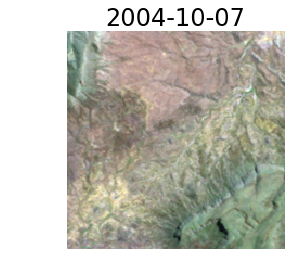

In [16]:
#first, clear the figure to keep memory usage down.
plt.clf()

#change the time index in this cell until you find a clean time slice to plot
#plt.figure(figsize=(12,10))

rgb = sensor_data_clear_scenes.isel(time =time_index).to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 4500
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)
plt.axis('off')
plt.imshow(scaled, interpolation = 'nearest',
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                   scaled.coords['y'].min(), scaled.coords['y'].max()])
plt.title('{0}'.format(np.array(sensor_data_clear_scenes.isel(time=time_index).time.values, dtype = 'datetime64[D]')), fontsize =24)
# plt.savefig('/g/data/r78/rjd547/groundwater_activities/Images/')
plt.show()

## Saving wetness for images slightly differently to preserve the ability to generate hov plots later

In [17]:
wetness_sensor1_nbar_for_images = wetness_sensor1_nbar
wetness_sensor2_nbar_for_images = wetness_sensor2_nbar
wetness_sensor3_nbar_for_images = wetness_sensor3_nbar

## calculate Tasselled Cap Wetness count through time

In [18]:
#we used wetness_multi for the hovmoller plots, so concatenate it for the images this time
wetness_multi_for_images = xr.concat([wetness_sensor1_nbar_for_images,
                                      wetness_sensor2_nbar_for_images,
                                      wetness_sensor3_nbar_for_images],
                                     dim = 'time')

#stop xarray from complaining about inequality
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #threshold here
    water_plus_wetveg = wetness_multi_for_images.where(wetness_multi_for_images>-400)

#count the number of wetness scenes for each pixel
wet_count = wetness_multi_for_images.count(dim = 'time')

#count the amount of times that water plus wet veg is above the threshold
threshold_count=water_plus_wetveg.count(dim='time')

#divide the number of times wetness is seen by the number of wetness scenes to get a proportion of time that the 
#pixel is wet or wet veg'd:
new_wet_count = threshold_count/wet_count

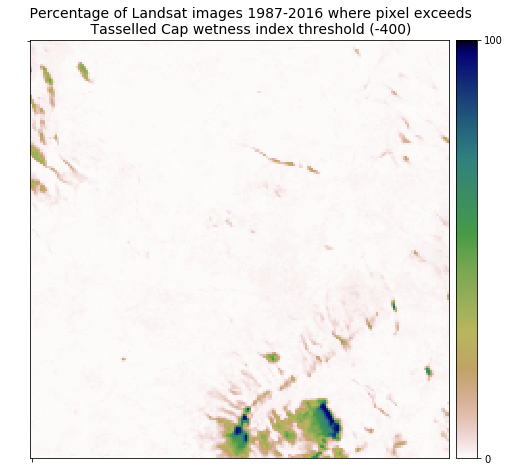

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

#clear figure to preserve memory
plt.clf()
#specify figure size
plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(1, 1)#, width_ratios=(12, 1))
#plot the image on the axes
ax1 = plt.subplot(gs[0,0])
img = ax1.imshow(new_wet_count, cmap='gist_earth_r',vmax=1.0, vmin =0.0)

#get rid of the axes labels and ticks
ax1.axes.set_xlabel('')
ax1.axes.set_xticklabels([''])
ax1.axes.set_xticks([0])
ax1.axes.set_ylabel('')
ax1.axes.set_yticklabels([''])
ax1.axes.set_yticks([0])

#set title
for_title = str('     Percentage of Landsat images 1987-2016 where pixel exceeds\n\
     Tasselled Cap wetness index threshold (-400)')
plt.title(for_title, 
          multialignment ='center',fontsize =14)#,
        # y=1.05, x =0.83)

#find the edge of the plot so that we can set the colourbar next to it
divider = make_axes_locatable(ax1)  
cax1 = divider.append_axes("right", size='5%', pad=0.1)
    
#set colourbar to same length as plot and set range to [0,100]    
cbar = plt.colorbar(img,cax=cax1, ticks =[0,1])
cbar.ax.set_yticklabels(['0','100'])


#plt.savefig('/g/data/r78/rjd547/groundwater_activities/Images/.png',
#box_inches='tight', pad_inches=0, transparent=True)

plt.show()


In [20]:
#make sure we are using the same time
time_chosen =sensor_data_clear_scenes.isel(time =time_index).time.values

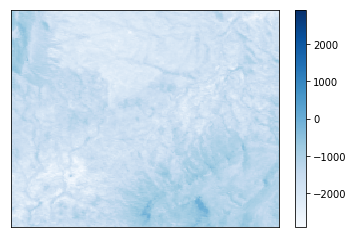

In [21]:
#plt.figure(figsize=(10,10))
wet_img = wetness_sensor1_nbar_for_images.sel(time=(time_chosen)).plot.imshow(cmap='Blues')#, vmax=1500, vmin =-2000)
wet_img.axes.set_xlabel('')
wet_img.axes.set_xticklabels([''])
wet_img.axes.set_xticks([0])
wet_img.axes.set_ylabel('')
wet_img.axes.set_yticklabels([''])
wet_img.axes.set_yticks([0])
plt.title('')
#plt.title('Tasselled Cap Wetness Index for Reeves Lake {0}'.format(np.array(sensor1_nbar.isel(time =57).time.values, dtype = 'datetime64[D]')), fontsize =10)
#plt.savefig('/g/data/r78/rjd547/groundwater_activities/Images/TCW_ReevesLake.png',
           # bbox_inches='tight', pad_inches=0)
plt.show()

### do for nbar_T

In [22]:
try:
    #try to get the NBARt and PQ data for sensor n from a pickle file saved earlier
    f = open(nbarpq_savein+'NBARt_data'+str(i)+'.pkl', 'rb')
    NBARtdata = pickle.load(f)
    sensor1_nbart = NBARtdata['sensor1_nbart']
    sensor1_pq = NBPQdata['sensor1_pq']
    sensor2_nbart = NBARtdata['sensor2_nbart']
    sensor2_pq = NBPQdata['sensor2_pq']
    sensor3_nbart = NBARtdata['sensor3_nbart']
    sensor3_pq = NBPQdata['sensor3_pq']
    print('loaded sensor NBARt from file')
    f.close()
except FileNotFoundError:
    #Retrieve the NBARt 
    sensor1_nbart = dc.load(product= sensor1+'_nbart_albers', group_by='solar_day', measurements = bands_of_interest,  **query)   
    print('loaded sensor1 NBARt from datacube')

    sensor2_nbart = dc.load(product= sensor2+'_nbart_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
    
    print('loaded sensor2 NBARt')

    sensor3_nbart = dc.load(product= sensor3+'_nbart_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
         
    print('loaded sensor3 NBARt')

    #make a dictionary of the data we want to save
    pickle_vars = {'sensor1_nbart':sensor1_nbart,
              'sensor2_nbart':sensor2_nbart,
              'sensor3_nbart':sensor3_nbart}

    f = open(nbarpq_savein+'NBARt_data'+str(i)+'.pkl', 'wb')
    pickle.dump(pickle_vars,f) 
    print('saved sensor NBARt to file')
    
    f.close()

loaded sensor NBARt from file


In [23]:
#save attributes
crs = sensor1_nbart.crs
crswkt = sensor1_nbart.crs.wkt
affine = sensor1_nbart.affine

#use masks from nbar
sensor1_nbart = sensor1_nbart.where(s1_good_data)    

sensor2_nbart = sensor2_nbart.where(s2_good_data)
sensor2_nbart.attrs['crs'] = crs
sensor2_nbart.attrs['affine'] = affine

sensor3_nbart = sensor3_nbart.where(s3_good_data)
sensor3_nbart.attrs['crs'] = crs
sensor3_nbart.attrs['affine'] = affine


In [24]:
### Choose a time index to plot a false color image

In [25]:
#finding clean time slices

#concatenate sensor data on time
sensort_data = xr.concat((sensor1_nbart,sensor2_nbart,sensor3_nbart), dim='time')
pernan = 0.99
sensort_data_clear_scenes = sensort_data.dropna('time',
#require this many non-nan pixels
    thresh = int(pernan*len(sensort_data.y)*len(sensort_data.x)))

In [26]:
### plot nbart image for time chosen

In [27]:
time_chosen

numpy.datetime64('2004-10-07T00:45:34.500000000')

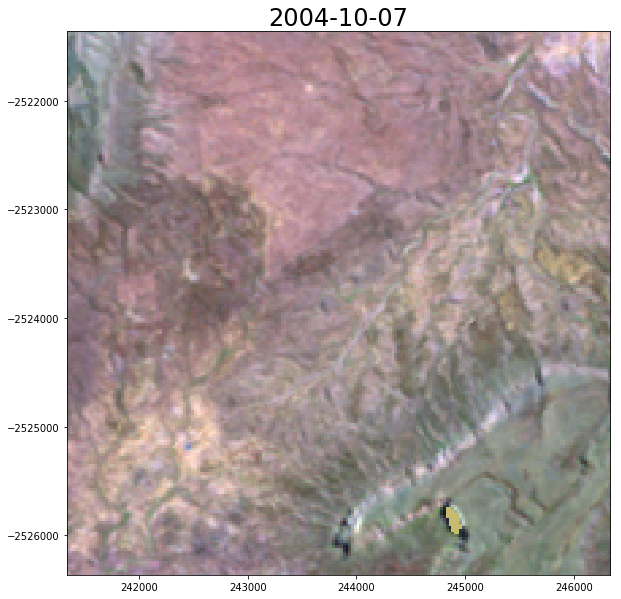

In [28]:
#first, clear the figure to keep memory usage down.
plt.clf()

#change the time index in this cell until you find a clean time slice to plot
plt.figure(figsize=(12,10))

rgb = sensort_data_clear_scenes.isel(time =time_index).to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 4500
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)
#plt.axis('off')
plt.imshow(scaled, interpolation = 'nearest',
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                   scaled.coords['y'].min(), scaled.coords['y'].max()])
plt.title('{0}'.format(np.array(sensort_data_clear_scenes.isel(time=time_index).time.values, dtype = 'datetime64[D]')), fontsize =24)
# plt.savefig('/g/data/r78/rjd547/groundwater_activities/Images/')
plt.show()

In [29]:

#Calculate Taselled Cap Wetness
wetness_sensor1_nbart = ((sensor1_nbart.blue*wetness_coeff[sensor1][0])+
                        (sensor1_nbart.green*wetness_coeff[sensor1][1])+
                        (sensor1_nbart.red*wetness_coeff[sensor1][2])+
                        (sensor1_nbart.nir*wetness_coeff[sensor1][3])+
                        (sensor1_nbart.swir1*wetness_coeff[sensor1][4])+
                        (sensor1_nbart.swir2*wetness_coeff[sensor1][5]))

wetness_sensor1_nbart.attrs['crs'] = crs
wetness_sensor1_nbart.attrs['affine'] = affine

wetness_sensor2_nbart = ((sensor2_nbart.blue*wetness_coeff[sensor2][0])+
                        (sensor2_nbart.green*wetness_coeff[sensor2][1])+
                        (sensor2_nbart.red*wetness_coeff[sensor2][2])+
                        (sensor2_nbart.nir*wetness_coeff[sensor2][3])+
                        (sensor2_nbart.swir1*wetness_coeff[sensor2][4])+
                        (sensor2_nbart.swir2*wetness_coeff[sensor2][5]))

wetness_sensor2_nbart.attrs['crs'] = crs
wetness_sensor2_nbart.attrs['affine'] = affine


wetness_sensor3_nbart = ((sensor3_nbart.blue*wetness_coeff[sensor3][0])+
                        (sensor3_nbart.green*wetness_coeff[sensor3][1])+
                        (sensor3_nbart.red*wetness_coeff[sensor3][2])+
                        (sensor3_nbart.nir*wetness_coeff[sensor3][3])+
                        (sensor3_nbart.swir1*wetness_coeff[sensor3][4])+
                        (sensor3_nbart.swir2*wetness_coeff[sensor3][5]))

wetness_sensor3_nbart.attrs['crs'] = crs
wetness_sensor3_nbart.attrs['affine'] = affine

In [30]:
wetness_sensor1_nbart_for_images = wetness_sensor1_nbart
wetness_sensor2_nbart_for_images = wetness_sensor2_nbart
wetness_sensor3_nbart_for_images = wetness_sensor3_nbart

In [31]:
#we used wetness_multi for the hovmoller plots, so concatenate it for the images this time
wetness_multit_for_images = xr.concat([wetness_sensor1_nbart_for_images,
                                      wetness_sensor2_nbart_for_images,
                                      wetness_sensor3_nbart_for_images],
                                     dim = 'time')

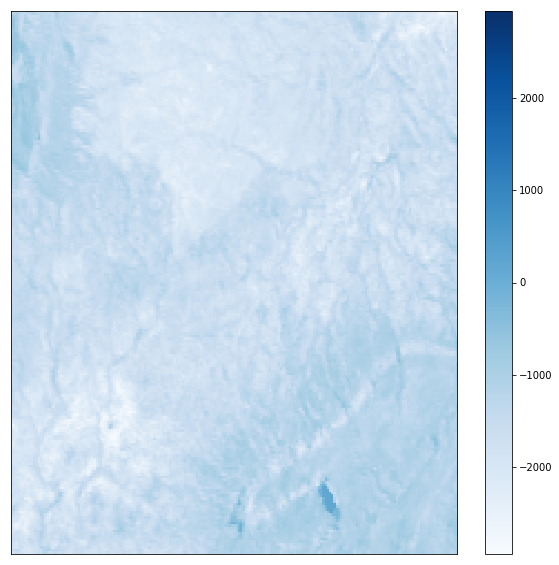

In [32]:
plt.figure(figsize=(10,10))
wet_img = wetness_sensor1_nbart_for_images.sel(time=(time_chosen)).plot.imshow(cmap='Blues')#, vmax=1500, vmin =-2000)
wet_img.axes.set_xlabel('')
wet_img.axes.set_xticklabels([''])
wet_img.axes.set_xticks([0])
wet_img.axes.set_ylabel('')
wet_img.axes.set_yticklabels([''])
wet_img.axes.set_yticks([0])
plt.title('')

plt.show()

In [33]:
#stop xarray from complaining about inequality
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #threshold here
    water_plus_wetvegt = wetness_multit_for_images.where(wetness_multit_for_images>-400)

#count the number of wetness scenes for each pixel
wet_countt = wetness_multit_for_images.count(dim = 'time')

#count the amount of times that water plus wet veg is above the threshold
threshold_countt=water_plus_wetvegt.count(dim='time')

#divide the number of times wetness is seen by the number of wetness scenes to get a proportion of time that the 
#pixel is wet or wet veg'd:
new_wet_countt = threshold_countt/wet_countt

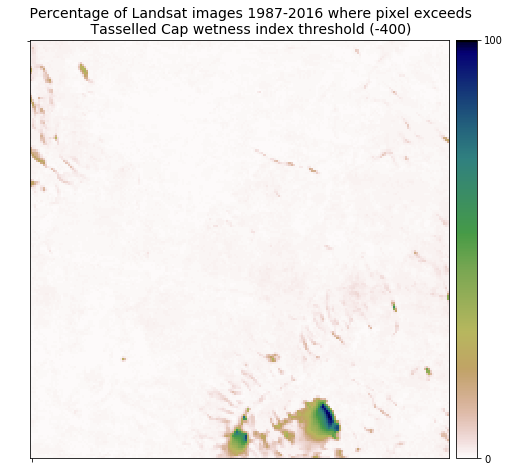

In [34]:
#clear figure to preserve memory
plt.clf()
#specify figure size
plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(1, 1)#, width_ratios=(12, 1))
#plot the image on the axes
ax1 = plt.subplot(gs[0,0])
img = ax1.imshow(new_wet_countt, cmap='gist_earth_r',vmax=1.0, vmin =0.0)

#get rid of the axes labels and ticks
ax1.axes.set_xlabel('')
ax1.axes.set_xticklabels([''])
ax1.axes.set_xticks([0])
ax1.axes.set_ylabel('')
ax1.axes.set_yticklabels([''])
ax1.axes.set_yticks([0])

#set title
for_title = str('     Percentage of Landsat images 1987-2016 where pixel exceeds\n\
     Tasselled Cap wetness index threshold (-400)')
plt.title(for_title, 
          multialignment ='center',fontsize =14)#,
        # y=1.05, x =0.83)

#find the edge of the plot so that we can set the colourbar next to it
divider = make_axes_locatable(ax1)  
cax1 = divider.append_axes("right", size='5%', pad=0.1)
    
#set colourbar to same length as plot and set range to [0,100]    
cbar = plt.colorbar(img,cax=cax1, ticks =[0,1])
cbar.ax.set_yticklabels(['0','100'])


#plt.savefig('/g/data/r78/rjd547/groundwater_activities/Images/.png',
#box_inches='tight', pad_inches=0, transparent=True)

plt.show()


In [35]:
#______________________in development############
#need to use nbart without including the nodata values

In [33]:
#first attempt at making a mask
#try returning nans instead of -999.0s
sensort_nbart=sensort_data_clear_scenes.where(sensort_data_clear_scenes!=-999.0)

In [36]:
#implement terrain correction correctly on nbart
sensor1_nbart_cor = sensor1_nbart.where(sensor1_nbart!=-999.0)
sensor2_nbart_cor = sensor2_nbart.where(sensor2_nbart!=-999.0)
sensor3_nbart_cor = sensor3_nbart.where(sensor3_nbart!=-999.0)

In [37]:
#get a list of the bands and the index of the corresponding bands
for (band,i) in zip(bands_of_interest, range(0,len(bands_of_interest))):
    print(band,i)

blue 0
green 1
red 2
nir 3
swir1 4
swir2 5


In [39]:
#Calculate Taselled Cap Wetness
wet_s1_nbart = ((sensor1_nbart_cor.blue*wetness_coeff[sensor1][0])+
                (sensor1_nbart_cor.green*wetness_coeff[sensor1][1])+
                (sensor1_nbart_cor.red*wetness_coeff[sensor1][2])+
                (sensor1_nbart_cor.nir*wetness_coeff[sensor1][3])+
                (sensor1_nbart_cor.swir1*wetness_coeff[sensor1][4])+
                (sensor1_nbart_cor.swir2*wetness_coeff[sensor1][5]))

In [40]:
wet_s1_nbart.attrs['crs'] = crs
wet_s1_nbart.attrs['affine'] = affine

wet_s2_nbart = ((sensor2_nbart_cor.blue*wetness_coeff[sensor2][0])+
                        (sensor2_nbart_cor.green*wetness_coeff[sensor2][1])+
                        (sensor2_nbart_cor.red*wetness_coeff[sensor2][2])+
                        (sensor2_nbart_cor.nir*wetness_coeff[sensor2][3])+
                        (sensor2_nbart_cor.swir1*wetness_coeff[sensor2][4])+
                        (sensor2_nbart_cor.swir2*wetness_coeff[sensor2][5]))

wet_s2_nbart.attrs['crs'] = crs
wet_s2_nbart.attrs['affine'] = affine


wet_s3_nbart = ((sensor3_nbart.blue*wetness_coeff[sensor3][0])+
                        (sensor3_nbart_cor.green*wetness_coeff[sensor3][1])+
                        (sensor3_nbart_cor.red*wetness_coeff[sensor3][2])+
                        (sensor3_nbart_cor.nir*wetness_coeff[sensor3][3])+
                        (sensor3_nbart_cor.swir1*wetness_coeff[sensor3][4])+
                        (sensor3_nbart_cor.swir2*wetness_coeff[sensor3][5]))

wet_s3_nbart.attrs['crs'] = crs
wet_s3_nbart.attrs['affine'] = affine

<xarray.DataArray ()>
array(-4706.180999999999)

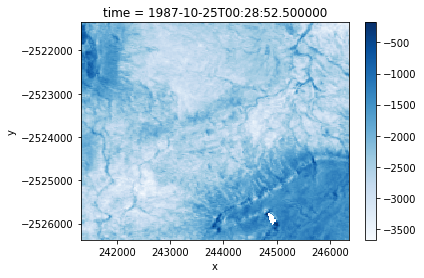

In [41]:
wet_s1_nbart.isel(time=(0)).plot.imshow(cmap='Blues')
wet_s1_nbart.min()

In [49]:
#we used wetness_multi for the hovmoller plots, so concatenate it for the images this time
wets_cor = xr.concat([wet_s1_nbart, wet_s2_nbart, wet_s3_nbart],
                     dim='time')

In [51]:
#stop xarray from complaining about inequality
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #threshold here
    water_plus_wetvegc = wets_cor.where(wets_cor>-400)

#count the number of wetness scenes for each pixel
wet_countc = wets_cor.count(dim = 'time')

#count the amount of times that water plus wet veg is above the threshold
threshold_countc=water_plus_wetvegc.count(dim='time')

#divide the number of times wetness is seen by the number of wetness scenes to get a proportion of time that the 
#pixel is wet or wet veg'd:
new_wet_countc = threshold_countc/wet_countc

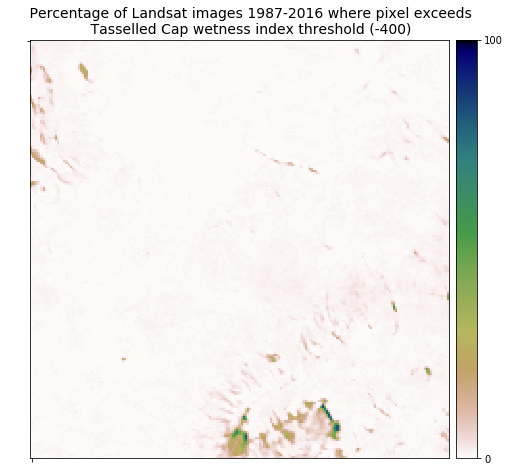

In [53]:
#clear figure to preserve memory
plt.clf()
#specify figure size
plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(1, 1)#, width_ratios=(12, 1))
#plot the image on the axes
ax1 = plt.subplot(gs[0,0])
img3 = ax1.imshow(new_wet_countc, cmap='gist_earth_r',vmax=1.0, vmin =0.0)

#get rid of the axes labels and ticks
ax1.axes.set_xlabel('')
ax1.axes.set_xticklabels([''])
ax1.axes.set_xticks([0])
ax1.axes.set_ylabel('')
ax1.axes.set_yticklabels([''])
ax1.axes.set_yticks([0])

#set title
for_title = str('     Percentage of Landsat images 1987-2016 where pixel exceeds\n\
     Tasselled Cap wetness index threshold (-400)')
plt.title(for_title, 
          multialignment ='center',fontsize =14)#,
        # y=1.05, x =0.83)

#find the edge of the plot so that we can set the colourbar next to it
divider = make_axes_locatable(ax1)  
cax1 = divider.append_axes("right", size='5%', pad=0.1)
    
#set colourbar to same length as plot and set range to [0,100]    
cbar = plt.colorbar(img,cax=cax1, ticks =[0,1])
cbar.ax.set_yticklabels(['0','100'])


#plt.savefig('/g/data/r78/rjd547/groundwater_activities/Images/.png',
#box_inches='tight', pad_inches=0, transparent=True)

plt.show()


## plot the three different tasselled cap wetness count images against the rgb - the image with no terrain correction, with incorrect terrain correction, and with correct terrain correction.

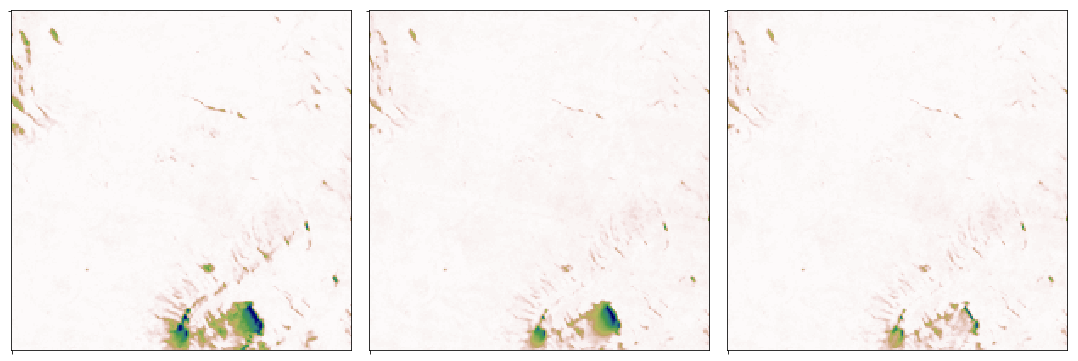

In [84]:
#clear figure to preserve memory
plt.clf()
#specify figure size
plt.figure(figsize=(20,8))
gs = gridspec.GridSpec(1, 4)#, width_ratios=(12, 1))

ax1 = plt.subplot(gs[0,0])
img = ax1.imshow(new_wet_count, cmap='gist_earth_r',vmax=1.0, vmin =0.0)

ax2 = plt.subplot(gs[0,1])
img2 = ax2.imshow(new_wet_countt, cmap='gist_earth_r',vmax=1.0, vmin =0.0)

#plot the image on the axes
ax3 = plt.subplot(gs[0,2])
img3 = ax3.imshow(new_wet_countc, cmap='gist_earth_r',vmax=1.0, vmin =0.0)


#get rid of the axes labels and ticks
for ax in [ax1,ax2,ax3]:
    ax.axes.set_xlabel('')
    ax.axes.set_xticklabels([''])
    ax.axes.set_xticks([0])
    ax.axes.set_ylabel('')
    ax.axes.set_yticklabels([''])
    ax.axes.set_yticks([0])



#plt.savefig('/g/data/r78/rjd547/groundwater_activities/Images/.png',
#box_inches='tight', pad_inches=0, transparent=True)
plt.tight_layout()
plt.show()